## Human Protein Multi Label Image Classification 

This is a starter notebook for the competition [Zero to GANs - Human Protein Classification](https://www.kaggle.com/c/jovian-pytorch-z2g)

In [1]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

## Exploring the Data

When you create a notebook with the "Notebooks" tab of a Kaggle competition, the data is automatically included in the `../input` folder. You can explore the files in the sidebar. Let us create some constants acess the data directories and CSV files.

In [2]:
DATA_DIR = '../input/jovian-pytorch-z2g/Human protein atlas'

TRAIN_DIR = DATA_DIR + '/train'                           # Contains training images
TEST_DIR = DATA_DIR + '/test'                             # Contains test images

TRAIN_CSV = DATA_DIR + '/train.csv'                       # Contains real labels for training images
TEST_CSV = '../input/jovian-pytorch-z2g/submission.csv'   # Contains dummy labels for test image

The `train.csv` file contains image IDs and labels for training data. Note that this is a multi-label classification problem. Each image can have more than one type of protein.

In [3]:
!head "{TRAIN_CSV}"

Image,Label
19567,9
29993,6 4
17186,1 4
29600,6 2
701,3 4
26562,9
1080,4
27886,4
30721,6


Similarly, `submission.csv` contains image IDs for test data. However, since the goal of this competition is to make predictions for the test set, the `submission.csv` files contains **dummy labels**, which you need to replace with your predictions and sumbit to the competition on the "Submission" tab. In other words, we don't have the labels for the test set.

In [4]:
!head "{TEST_CSV}"

Image,Label
24117,0
15322,0
14546,0
8079,0
13192,0
25927,0
3372,0
21781,0
2847,0


The image files are named `<image-id>.png` and can be found in the respective `train` and `test` folders.

In [5]:
!ls "{TRAIN_DIR}" | head

0.png
1.png
10000.png
10001.png
10005.png
10008.png
10009.png
10012.png
10013.png
10014.png
ls: write error: Broken pipe


Let's load the `train.csv` file into a Pandas dataframe

In [6]:
train_df = pd.read_csv(TRAIN_CSV)
train_df.head()

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4


Let's also put the textual labels in a dictionary for later use.

In [7]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

To create a tensor from the labels, we will encode the labels as vectors of 1s & 0s. For example, if the labels are `'2 4 5'`, the correspoding vector for it would be `[0, 0, 1, 0, 1, 1, 0, 0, 0, 0]`. Let's define helper funtions to encode labels into tensors and vice versa.

In [8]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)
    

In [9]:
encode_label('2 4 5')

tensor([0., 0., 1., 0., 1., 1., 0., 0., 0., 0.])

In [10]:
decode_target(torch.tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0.]))

'2 4 5'

In [11]:
decode_target(torch.tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0.]), text_labels=True)

'Nucleoli(2) Nucleoplasm(4) Nucleoli fibrillar center(5)'

## Creating Datasets & Data Loaders

We can now create a custom dataset by extending the `Dataset` class from PyTorch. We need to define the `__len__` and `__getitem__` methods to create a dataset. We'll also provide the option of adding transforms into the constructor.

In [12]:
class HumanProteinDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

Transforms can be chained using `transforms.Compose`. For instance, you may add `transforms.Resize(128)` before `transforms.ToTensor()` to resize images to size 128x128 before converting them into tensors. See the full list of transforms here: https://pytorch.org/docs/master/torchvision/transforms.html

In [13]:
transform = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor()])
dataset = HumanProteinDataset(TRAIN_CSV, TRAIN_DIR, transform=transform)

Let's check how many samples the dataset contains

In [14]:
len(dataset)

19236

Let's take a look at a sample image from the dataset. We'll define a function `show_sample` to help us. We will also include the option to invert the image before showing it, because the original images are quite dark.

In [15]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))
    

Here's a sample image without the colors inverted.

Labels: Nuclear speckles(9)


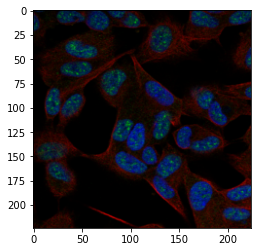

In [16]:
show_sample(*dataset[0], invert=False)

Here's the same image viewed with the colors inverted

Labels: Nuclear speckles(9)


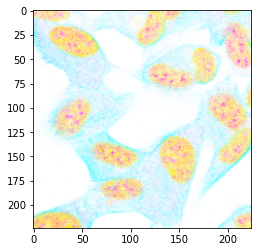

In [17]:
show_sample(*dataset[0])

### Training & Validation sets

As a good practice, we should split the data into training and validation datasets. Let's fix a seed for PyTorch (to ensure we always get the same validation set), and create the datasets using `random_split`.

In [18]:
torch.manual_seed(100)

I'm using a validation percentage of 10%, but you can use a smaller or larger percentage. One good strategy is to determine a good set of hyperparameters, and then retrain on a smaller validation set for your final submission.

In [19]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

In [20]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(17313, 1923)

### Data Loaders

In [21]:
batch_size = 64

In [22]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [23]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

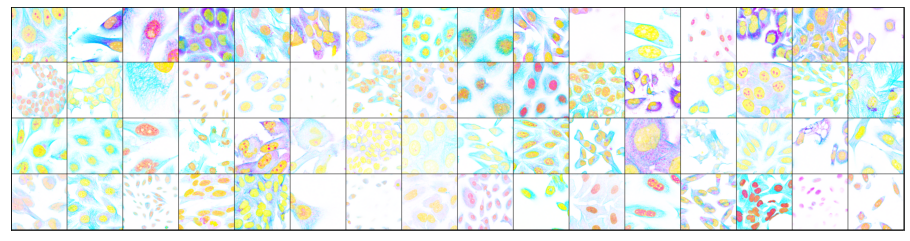

In [24]:
show_batch(train_dl)

## Model

In [37]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [38]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
#        loss = F.cross_entropy(out, targets)      
        loss = F.binary_cross_entropy(out, targets)
        return loss

    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions#
#        loss = F.cross_entropy(out, targets)  # Calculate loss     !!why is it binary ??      
        loss = F.binary_cross_entropy(out, targets)
#        loss(out, targets)
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))

In [39]:
class ProteinCnnModel3(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.vgg16(pretrained=True)
        # Replace last layer
#        self.network.classifier[6].out_features = 10
        for param in self.network.features.parameters():
            param.requires_grad = False
        # Newly created modules have require_grad=True by default
        num_features = self.network.classifier[6].in_features
        features = list(self.network.classifier.children())[:-1] # Remove last layer
        features.extend([nn.Linear(num_features, 10)]) # Add our layer with 4 outputs
        self.network.classifier = nn.Sequential(*features) # Replace the model classifier
            
            
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [40]:
model = ProteinCnnModel3()
model

ProteinCnnModel3(
  (network): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
 

In [41]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [42]:
device = get_default_device()
device

device(type='cuda')

In [43]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [44]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(train_dl)

images.shape: torch.Size([64, 3, 224, 224])
out.shape: torch.Size([64, 10])
out[0]: tensor([0.5466, 0.3215, 0.5756, 0.5851, 0.6425, 0.3402, 0.4191, 0.6450, 0.5705,
        0.3280], device='cuda:0', grad_fn=<SelectBackward>)


If your kernel runs out of memory here, you might need to reduce your batch size.

## Training the model

In [45]:
from tqdm.notebook import tqdm

In [46]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [47]:
model = to_device(ProteinCnnModel3(), device)

In [48]:
evaluate(model, val_dl) 

{'val_loss': 0.7052620649337769, 'val_score': 0.2928750514984131}

In [49]:
num_epochs = 100
opt_func = torch.optim.Adam
lr = 1e-4

In [50]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.3569, val_loss: 0.3270, val_score: 0.3731



Epoch [1], train_loss: 0.3390, val_loss: 0.3228, val_score: 0.3455



Epoch [2], train_loss: 0.3329, val_loss: 0.3174, val_score: 0.4465



Epoch [3], train_loss: 0.3288, val_loss: 0.3173, val_score: 0.3968



Epoch [4], train_loss: 0.3250, val_loss: 0.3079, val_score: 0.4441



Epoch [5], train_loss: 0.3227, val_loss: 0.3101, val_score: 0.4137



Epoch [6], train_loss: 0.3198, val_loss: 0.3088, val_score: 0.4000



Epoch [7], train_loss: 0.3175, val_loss: 0.3094, val_score: 0.4337



Epoch [8], train_loss: 0.3160, val_loss: 0.3080, val_score: 0.4288



Epoch [9], train_loss: 0.3131, val_loss: 0.3103, val_score: 0.4312



Epoch [10], train_loss: 0.3118, val_loss: 0.3079, val_score: 0.4437



Epoch [11], train_loss: 0.3105, val_loss: 0.3057, val_score: 0.4608



Epoch [12], train_loss: 0.3090, val_loss: 0.3026, val_score: 0.4496



Epoch [13], train_loss: 0.3072, val_loss: 0.3061, val_score: 0.4214



Epoch [14], train_loss: 0.3058, val_loss: 0.3072, val_score: 0.4433



Epoch [15], train_loss: 0.3034, val_loss: 0.3071, val_score: 0.4587



Epoch [16], train_loss: 0.3027, val_loss: 0.3090, val_score: 0.4296



Epoch [17], train_loss: 0.3005, val_loss: 0.3067, val_score: 0.4738



Epoch [18], train_loss: 0.3002, val_loss: 0.3053, val_score: 0.4236



Epoch [19], train_loss: 0.2993, val_loss: 0.3011, val_score: 0.4544



Epoch [20], train_loss: 0.2972, val_loss: 0.3008, val_score: 0.4760



Epoch [21], train_loss: 0.2961, val_loss: 0.3086, val_score: 0.4645



Epoch [22], train_loss: 0.2954, val_loss: 0.3038, val_score: 0.4443



Epoch [23], train_loss: 0.2954, val_loss: 0.3002, val_score: 0.4463



Epoch [24], train_loss: 0.2913, val_loss: 0.3021, val_score: 0.4810



Epoch [25], train_loss: 0.2910, val_loss: 0.3010, val_score: 0.4816



Epoch [26], train_loss: 0.2905, val_loss: 0.3012, val_score: 0.4700



Epoch [27], train_loss: 0.2882, val_loss: 0.3071, val_score: 0.4898



Epoch [28], train_loss: 0.2871, val_loss: 0.3089, val_score: 0.4436



Epoch [29], train_loss: 0.2860, val_loss: 0.3044, val_score: 0.4793



Epoch [30], train_loss: 0.2859, val_loss: 0.2989, val_score: 0.4706



Epoch [31], train_loss: 0.2832, val_loss: 0.3045, val_score: 0.4647



Epoch [32], train_loss: 0.2835, val_loss: 0.3040, val_score: 0.4803



Epoch [33], train_loss: 0.2817, val_loss: 0.3031, val_score: 0.4787



Epoch [34], train_loss: 0.2799, val_loss: 0.3065, val_score: 0.4431



Epoch [35], train_loss: 0.2799, val_loss: 0.3092, val_score: 0.4801



Epoch [36], train_loss: 0.2791, val_loss: 0.3045, val_score: 0.4750



Epoch [37], train_loss: 0.2780, val_loss: 0.3029, val_score: 0.4880



Epoch [38], train_loss: 0.2754, val_loss: 0.3043, val_score: 0.4756



Epoch [39], train_loss: 0.2748, val_loss: 0.3062, val_score: 0.4708



Epoch [40], train_loss: 0.2721, val_loss: 0.3052, val_score: 0.4694



Epoch [41], train_loss: 0.2731, val_loss: 0.3009, val_score: 0.4746



Epoch [42], train_loss: 0.2719, val_loss: 0.3064, val_score: 0.4926



Epoch [43], train_loss: 0.2707, val_loss: 0.3055, val_score: 0.4916



Epoch [44], train_loss: 0.2700, val_loss: 0.3055, val_score: 0.4712



Epoch [45], train_loss: 0.2686, val_loss: 0.3083, val_score: 0.4671



Epoch [46], train_loss: 0.2682, val_loss: 0.3057, val_score: 0.4855



Epoch [47], train_loss: 0.2674, val_loss: 0.3036, val_score: 0.4964



Epoch [48], train_loss: 0.2650, val_loss: 0.3111, val_score: 0.4713



Epoch [49], train_loss: 0.2637, val_loss: 0.3126, val_score: 0.4729



Epoch [50], train_loss: 0.2635, val_loss: 0.3039, val_score: 0.5045



Epoch [51], train_loss: 0.2619, val_loss: 0.3108, val_score: 0.4596



Epoch [52], train_loss: 0.2600, val_loss: 0.3080, val_score: 0.4886



Epoch [53], train_loss: 0.2598, val_loss: 0.3048, val_score: 0.5003



Epoch [54], train_loss: 0.2591, val_loss: 0.3085, val_score: 0.4778



Epoch [55], train_loss: 0.2575, val_loss: 0.3087, val_score: 0.4901



Epoch [56], train_loss: 0.2576, val_loss: 0.3058, val_score: 0.4953



Epoch [57], train_loss: 0.2574, val_loss: 0.3066, val_score: 0.4949



Epoch [58], train_loss: 0.2550, val_loss: 0.3100, val_score: 0.4676



Epoch [59], train_loss: 0.2527, val_loss: 0.3112, val_score: 0.4839



Epoch [60], train_loss: 0.2545, val_loss: 0.3085, val_score: 0.4723



Epoch [61], train_loss: 0.2530, val_loss: 0.3104, val_score: 0.4960



Epoch [62], train_loss: 0.2528, val_loss: 0.3090, val_score: 0.4622



Epoch [63], train_loss: 0.2495, val_loss: 0.3126, val_score: 0.4733



Epoch [64], train_loss: 0.2500, val_loss: 0.3186, val_score: 0.4839



Epoch [65], train_loss: 0.2483, val_loss: 0.3019, val_score: 0.5147



Epoch [66], train_loss: 0.2478, val_loss: 0.3068, val_score: 0.5044



Epoch [67], train_loss: 0.2474, val_loss: 0.3090, val_score: 0.4956



Epoch [68], train_loss: 0.2456, val_loss: 0.3065, val_score: 0.5130



Epoch [69], train_loss: 0.2461, val_loss: 0.3155, val_score: 0.4759



Epoch [70], train_loss: 0.2448, val_loss: 0.3115, val_score: 0.4846



Epoch [71], train_loss: 0.2429, val_loss: 0.3150, val_score: 0.4860



Epoch [72], train_loss: 0.2446, val_loss: 0.3150, val_score: 0.4907



Epoch [73], train_loss: 0.2424, val_loss: 0.3110, val_score: 0.5033



Epoch [74], train_loss: 0.2431, val_loss: 0.3118, val_score: 0.4827



Epoch [75], train_loss: 0.2429, val_loss: 0.3105, val_score: 0.5041



Epoch [76], train_loss: 0.2397, val_loss: 0.3127, val_score: 0.4724



Epoch [77], train_loss: 0.2405, val_loss: 0.3114, val_score: 0.4917



Epoch [78], train_loss: 0.2390, val_loss: 0.3106, val_score: 0.4964



Epoch [79], train_loss: 0.2389, val_loss: 0.3111, val_score: 0.4993



Epoch [80], train_loss: 0.2373, val_loss: 0.3175, val_score: 0.4926



Epoch [81], train_loss: 0.2357, val_loss: 0.3111, val_score: 0.5048



Epoch [82], train_loss: 0.2372, val_loss: 0.3107, val_score: 0.5007



Epoch [83], train_loss: 0.2357, val_loss: 0.3104, val_score: 0.5096



Epoch [84], train_loss: 0.2339, val_loss: 0.3142, val_score: 0.4911



Epoch [85], train_loss: 0.2346, val_loss: 0.3167, val_score: 0.4861



Epoch [86], train_loss: 0.2346, val_loss: 0.3106, val_score: 0.5158



Epoch [87], train_loss: 0.2312, val_loss: 0.3094, val_score: 0.5068



Epoch [88], train_loss: 0.2322, val_loss: 0.3145, val_score: 0.4778



Epoch [89], train_loss: 0.2296, val_loss: 0.3110, val_score: 0.4972



Epoch [90], train_loss: 0.2298, val_loss: 0.3106, val_score: 0.5105



Epoch [91], train_loss: 0.2300, val_loss: 0.3147, val_score: 0.4996



Epoch [92], train_loss: 0.2293, val_loss: 0.3173, val_score: 0.5082



Epoch [93], train_loss: 0.2298, val_loss: 0.3139, val_score: 0.4718



Epoch [94], train_loss: 0.2295, val_loss: 0.3183, val_score: 0.5033



Epoch [95], train_loss: 0.2258, val_loss: 0.3203, val_score: 0.5106



Epoch [96], train_loss: 0.2274, val_loss: 0.3148, val_score: 0.4770



Epoch [97], train_loss: 0.2271, val_loss: 0.3173, val_score: 0.4995



Epoch [98], train_loss: 0.2247, val_loss: 0.3120, val_score: 0.5030



Epoch [99], train_loss: 0.2253, val_loss: 0.3159, val_score: 0.4867


In [51]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [52]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

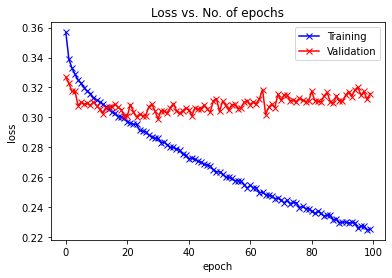

In [53]:
plot_losses(history)

## Making predictions & submission

To start with, let's create a helper function to make a prediction on a single image.

In [54]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

Next, let's create a test dataset using the `submission.csv` file. Note that the file contains dummy labels (always `'0'`). We'll use the same transforms we used for the training set.

In [55]:
test_dataset = HumanProteinDataset(TEST_CSV, TEST_DIR, transform=transform)

In [56]:
img, target = test_dataset[0]
img.shape

torch.Size([3, 224, 224])

Let's try predicting the labels for some sample images

Prediction:  tensor([0.3994, 0.0944, 0.1542, 0.1587, 0.7906, 0.1665, 0.4801, 0.2763, 0.0910,
        0.0630], device='cuda:0', grad_fn=<SelectBackward>)
Labels: Nucleoplasm(4)


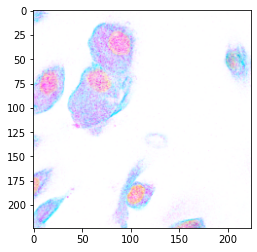

In [57]:
predict_single(test_dataset[100][0])

Prediction:  tensor([7.9559e-01, 2.3779e-03, 6.8141e-03, 1.3003e-01, 1.9615e-01, 1.0171e-03,
        5.3777e-02, 6.1798e-02, 8.6340e-03, 6.8781e-04], device='cuda:0',
       grad_fn=<SelectBackward>)
Labels: Mitochondria(0)


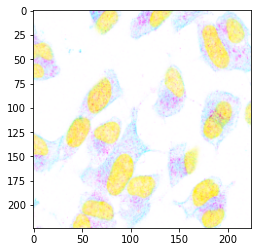

In [58]:
predict_single(test_dataset[74][0])

## Creating a submission file

In [59]:
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True), device)

In [60]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [61]:
test_preds = predict_dl(test_dl, model)

Let us know create a submission file with these predictions

In [62]:
submission_df = pd.read_csv(TEST_CSV)
submission_df.Label = test_preds
submission_df.head()

,Image,Label
0,24117,4
1,15322,4
2,14546,0
3,8079,0 7
4,13192,4


We can now save it batck to CSV, and download the file from the sidebar (check the output folder)

In [63]:
sub_fname = 'resnet34_submission.csv'

In [64]:
submission_df.to_csv(sub_fname, index=False)

You can now upload this submission file here: https://www.kaggle.com/c/jovian-pytorch-z2g/submit

## Save to Jovian

In [65]:
!pip install jovian --upgrade

     |████████████████████████████████| 94 kB 1.7 MB/s eta 0:00:011
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6500 sha256=b88ca9a23b4cfdec74caa52c32069b603a31240b086aa9ec342f9ddfb64be809
  Stored in directory: /root/.cache/pip/wheels/2a/ea/87/dd57f1ecb4f0752f3e1dbf958ebf8b36d920d190425bcdc24d
Successfully built uuid


In [66]:
import jovian

<IPython.core.display.Javascript object>

In [ ]:
jovian.commit(project='VGG16 for jovian competition')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/m-chemseddine/VGG16 for jovian competition


<IPython.core.display.Javascript object>

You can also use the "Save Version" button on Kaggle itself, to save a copy on your Kaggle profile.